Dataset Link: https://www.kaggle.com/amyjang/alzheimer-mri-model-tensorflow-2-3-data-loading

In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from matplotlib import pyplot as plt
import pickle

tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
gpu_device = tf.config.list_physical_devices('GPU')[0]
gpu_device

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
tf.config.experimental.get_device_details(gpu_device)['device_name']

'NVIDIA GeForce GTX 1650 Ti'

In [3]:
tf.__version__

'2.6.0'

In [4]:
train_dataset_dir = ".\\Alzheimer_s Dataset\\train"
test_dataset_dir = ".\\Alzheimer_s Dataset\\test"
IMG_SIZE = (208, 176)
BATCH_SIZE = 16
EPOCHS = 100
COLOR_MODE = 'grayscale'
CHANNELS = 3 if COLOR_MODE == 'rgb' else 1
N_LABELS = len(os.listdir(train_dataset_dir))
DTYPE = tf.float32

In [5]:
train_datagen = ImageDataGenerator(data_format='channels_last',
                                   validation_split=0.2,
                                   rescale=1.0 / 255.0,
                                   dtype=DTYPE)

test_datagen = ImageDataGenerator(data_format='channels_last',
                                  validation_split=0,
                                  rescale=1.0 / 255.0,
                                  dtype=DTYPE)

In [6]:
train_generator = train_datagen.flow_from_directory(directory=train_dataset_dir,
                                                    target_size=IMG_SIZE,
                                                    color_mode=COLOR_MODE,
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    subset='training',
                                                    batch_size=BATCH_SIZE)

Found 4098 images belonging to 4 classes.


In [7]:
val_generator = train_datagen.flow_from_directory(directory=train_dataset_dir,
                                                  target_size=IMG_SIZE,
                                                  color_mode=COLOR_MODE,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  subset='validation',
                                                  batch_size=BATCH_SIZE)

Found 1023 images belonging to 4 classes.


In [8]:
test_generator = test_datagen.flow_from_directory(directory=test_dataset_dir,
                                                  target_size=IMG_SIZE,
                                                  color_mode=COLOR_MODE,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  subset='training',
                                                  batch_size=BATCH_SIZE)

Found 1279 images belonging to 4 classes.


In [9]:
@keras.utils.register_keras_serializable()
class ConvBlock(layers.Layer):
    def __init__(self, conv_filters, conv_kernel_size, **kwargs):
        super(ConvBlock, self).__init__()
        self.conv_filters = conv_filters
        self.conv_kernel_size = conv_kernel_size

        self.conv1 = layers.Conv2D(self.conv_filters, self.conv_kernel_size, padding='same', activation=layers.LeakyReLU())
        self.conv2 = layers.Conv2D(self.conv_filters, self.conv_kernel_size, padding='same', activation=layers.LeakyReLU())
        self.bn = layers.BatchNormalization()
        self.maxpool = layers.MaxPooling2D(pool_size=2, strides=2)
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'conv_filters': self.conv_filters,
            'conv_kernel_size': self.conv_kernel_size
        })
        return config
    
    @tf.function()
    def call(self, tensor, training=False):
        tensor = self.conv1(tensor)
        tensor = self.conv2(tensor)
        tensor = self.bn(tensor, training=training)
        tensor = self.maxpool(tensor)
        return tensor

In [10]:
@keras.utils.register_keras_serializable()
class DenseBlock(layers.Layer):
    def __init__(self, units, dropout_rate=0, **kwargs):
        super(DenseBlock, self).__init__()
        self.units = units
        self.dropout_rate = dropout_rate

        self.dense = layers.Dense(self.units, activation=layers.LeakyReLU())
        self.bn = layers.BatchNormalization()
        if self.dropout_rate != 0:
            self.dropout = layers.Dropout(self.dropout_rate)
            
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'units': self.units,
            'dropout_rate': self.dropout_rate
        })
        return config
    
    @tf.function()
    def call(self, tensor):
        tensor = self.dense(tensor)
        tensor = self.bn(tensor)
        if self.dropout_rate != 0:
            tensor = self.dropout(tensor)
        return tensor

In [11]:
class Model(keras.Model):
    def __init__(self, n_labels=N_LABELS):
        super(Model, self).__init__()

        self.convblock1 = ConvBlock(32, 3)
        self.convblock2 = ConvBlock(64, 3)
        self.convblock3 = ConvBlock(128, 3)
        self.convblock4 = ConvBlock(256, 3)
        self.convblock5 = ConvBlock(256, 3)
        self.dropout = layers.Dropout(0.3)
        self.flatten = layers.Flatten()
        self.dense1 = DenseBlock(512, 0.5)
        self.dense2 = DenseBlock(256, 0.3)
        self.dense3 = DenseBlock(128, 0.2)
        self.outputs = layers.Dense(n_labels)

    @tf.function
    def call(self, tensor):
        tensor = self.convblock1(tensor)
        tensor = self.convblock2(tensor)
        tensor = self.convblock3(tensor)
        tensor = self.convblock4(tensor)
        tensor = self.convblock5(tensor)
        tensor = self.dropout(tensor)
        tensor = self.flatten(tensor)
        tensor = self.dense1(tensor)
        tensor = self.dense2(tensor)
        tensor = self.dense3(tensor)
        tensor = self.outputs(tensor)
        return tensor

In [12]:
sequential_layers = [layers.InputLayer(input_shape=(*IMG_SIZE, CHANNELS))]
sequential_layers.extend(Model(n_labels=N_LABELS).layers)
model = keras.Sequential(sequential_layers)
model_name = "Alzheimers_Model"

lr_scheduler = keras.optimizers.schedules.InverseTimeDecay(1e-4, decay_steps=len(train_generator), decay_rate=0.9)

monitor = 'val_acc'
early_stopping = keras.callbacks.EarlyStopping(monitor=monitor, patience=10, restore_best_weights=True)
best_checkpoint = keras.callbacks.ModelCheckpoint(filepath=f"{model_name}.h5",
                                                          monitor=monitor,
                                                          save_best_only=True,
                                                          save_freq='epoch',
                                                          verbose=1)
callbacks = [early_stopping, best_checkpoint]

keras.utils.plot_model(model, to_file=f"{model_name} Structure.png", show_shapes=True)

model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(learning_rate=lr_scheduler),
              metrics=[keras.metrics.CategoricalAccuracy(name='acc')])

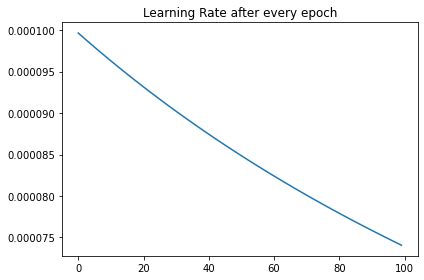

In [13]:
plt.figure()
plt.plot([lr_scheduler(step=x) for x in range(1, EPOCHS+1)])
plt.title("Learning Rate after every epoch")
plt.tight_layout()
plt.show()

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_block (ConvBlock)       (None, 104, 88, 32)       9696      
_________________________________________________________________
conv_block_1 (ConvBlock)     (None, 52, 44, 64)        55680     
_________________________________________________________________
conv_block_2 (ConvBlock)     (None, 26, 22, 128)       221952    
_________________________________________________________________
conv_block_3 (ConvBlock)     (None, 13, 11, 256)       886272    
_________________________________________________________________
conv_block_4 (ConvBlock)     (None, 6, 5, 256)         1181184   
_________________________________________________________________
dropout (Dropout)            (None, 6, 5, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 7680)              0

In [15]:
train = model.fit(train_generator,
                  epochs=EPOCHS,
                  verbose=1,
                  workers=-1,
                  use_multiprocessing=True,
                  validation_data=val_generator,
                  callbacks=callbacks)

Epoch 1/100
257/257 [==============================] - 39s 131ms/step - loss: 0.9694 - acc: 0.5791 - val_loss: 1.7090 - val_acc: 0.5005

Epoch 00001: val_acc improved from -inf to 0.50049, saving model to Alzheimers_Model.h5
Epoch 2/100
257/257 [==============================] - 42s 165ms/step - loss: 0.5753 - acc: 0.7609 - val_loss: 1.2590 - val_acc: 0.5973

Epoch 00002: val_acc improved from 0.50049 to 0.59726, saving model to Alzheimers_Model.h5
Epoch 3/100
257/257 [==============================] - 38s 148ms/step - loss: 0.2469 - acc: 0.9136 - val_loss: 0.9101 - val_acc: 0.6158

Epoch 00003: val_acc improved from 0.59726 to 0.61584, saving model to Alzheimers_Model.h5
Epoch 4/100
257/257 [==============================] - 41s 161ms/step - loss: 0.0686 - acc: 0.9832 - val_loss: 0.6852 - val_acc: 0.7312

Epoch 00004: val_acc improved from 0.61584 to 0.73118, saving model to Alzheimers_Model.h5
Epoch 5/100
257/257 [==============================] - 43s 167ms/step - loss: 0.0376 - acc:

In [16]:
model = keras.models.load_model(f"{model_name}.h5")

In [17]:
test = model.evaluate(test_generator,
                      workers=-1,
                      use_multiprocessing=True,
                      verbose=1)

80/80 [==============================] - 24s 301ms/step - loss: 1.2913 - acc: 0.7099


In [18]:
train_history = pd.DataFrame(train.history)
train_history.head()

,loss,acc,val_loss,val_acc
0,0.969428,0.579063,1.708997,0.500489
1,0.575257,0.760859,1.258973,0.597263
2,0.246928,0.913616,0.910123,0.615836
3,0.068618,0.983163,0.685222,0.731183
4,0.037584,0.991459,0.960310,0.674487


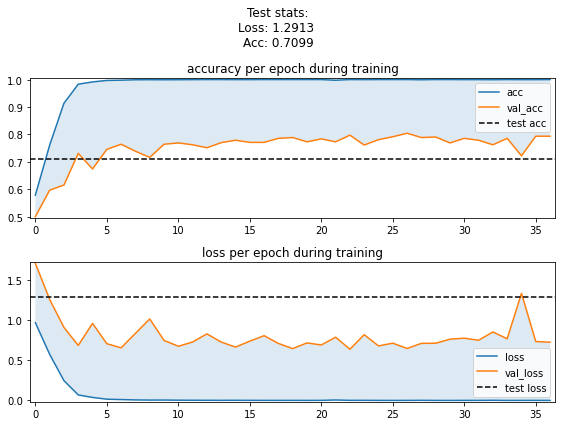

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].plot(train_history['acc'], label='acc')
ax[0].plot(train_history['val_acc'], label='val_acc')
ax[0].fill_between(x=train_history.index, y1=train_history['acc'], y2=train_history['val_acc'], alpha=0.15)
ax[0].axhline(test[1], color='black', label='test acc', linestyle='--')
ax[0].legend(loc='best')
ax[0].margins(x=0.01, y=0.01)
ax[0].set_title('accuracy per epoch during training')

ax[1].plot(train_history['loss'], label='loss')
ax[1].plot(train_history['val_loss'], label='val_loss')
ax[1].fill_between(x=train_history.index, y1=train_history['loss'], y2=train_history['val_loss'], alpha=0.15)
ax[1].axhline(test[0], color='black', label='test loss', linestyle='--')
ax[1].legend(loc='best')
ax[1].margins(x=0.01, y=0.01)
ax[1].set_title('loss per epoch during training')

plt.suptitle(f"Test stats:\nLoss: {round(test[0], 4)} \nAcc: {round(test[1], 4)}")
plt.tight_layout()
plt.show()